In [1]:
import pandas as pd
import numpy as np

## for data visualisation
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from datetime import date
import os
import requests

In [94]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

import pymc3 as pm
import matplotlib.pyplot as plt

In [3]:
import statsmodels.formula.api as smf
import statsmodels.api as sm


In [306]:
df = pd.read_csv('traffic_pollution.csv')
df

code        date   hour  total  value  temp  wspd  prcp  coco
0            Esch  2022-01-01  01:00    442   19.0  10.0  10.8   0.0   5.0
1      Luxembourg  2022-01-01  01:00    290   16.0  10.0  10.8   0.0   5.0
2            Esch  2022-01-02  01:00    290   17.0   6.6  10.8   0.0   1.0
3      Luxembourg  2022-01-02  01:00     88   17.0   6.6  10.8   0.0   1.0
4            Esch  2022-01-03  01:00    198   16.0   8.2  25.2   0.0   5.0
...           ...         ...    ...    ...    ...   ...   ...   ...   ...
34027  Luxembourg  2021-03-27  23:00    430   21.0   5.5  14.4   0.0   5.0
34028  Luxembourg  2021-03-29  23:00    350   26.0  11.5   3.6   0.0   1.0
34029  Luxembourg  2021-03-30  23:00    536   23.0  17.0  10.8   0.0   1.0
34030  Luxembourg  2021-05-27  23:00    528   16.0  11.0  14.4   0.0   1.0
34031  Luxembourg  2021-03-26  23:00    564   15.0   8.2  14.4   0.0   5.0

[34032 rows x 9 columns]

## Modelling

In [307]:
df['hour'] = df['hour'].str.split(':').str[0].astype(int)

In [308]:
df.value.describe()

count    34032.000000
mean        29.677465
std         17.704233
min          1.000000
25%         16.000000
50%         26.000000
75%         41.000000
max        138.000000
Name: value, dtype: float64

In [309]:
df.isna().any(axis=0)

code     False
date     False
hour     False
total    False
value    False
temp     False
wspd     False
prcp     False
coco     False
dtype: bool

In [310]:
nan_counts = df.isna().sum()
nan_counts

code     0
date     0
hour     0
total    0
value    0
temp     0
wspd     0
prcp     0
coco     0
dtype: int64

### Features

In [311]:
df_tmp = df


In [312]:
df = df_tmp

In [313]:
#df = df[(df.hour<7) | (df.hour>=21)]
df = df[(df.hour>=7) ]#& (df.hour<21)
#df['rush'] = ((df.hour>=7) & (df.hour<21)).astype('uint8')
### to have reliable data
df = df[df['date']>='2020-03-01']

In [314]:
df['code'] = df['code'].astype('category')

#df['hour'] = df['hour'].astype('category')
#df['coco'] = df['coco'].astype('category')

In [315]:
max(df.date)

'2022-12-31'

In [316]:
categorical_features = ['code']#, 'hour'
encoded_features = pd.get_dummies(df[categorical_features], drop_first=True)
encoded_features

code_Luxembourg
8221                 0
8222                 1
8223                 0
8224                 1
8225                 0
...                ...
34027                1
34028                1
34029                1
34030                1
34031                1

[25780 rows x 1 columns]

In [317]:
df = df.drop(categorical_features, axis=1)  # Drop original categorical columns
df = pd.concat([df, encoded_features], axis=1)  # Add new encoded columns

In [318]:
df = df.drop(['hour', 'date', 'coco'], axis=1)#

In [319]:
df.dtypes

total                int64
value              float64
temp               float64
wspd               float64
prcp               float64
code_Luxembourg      uint8
dtype: object

In [320]:
df.total.describe()

count    25780.000000
mean      1416.330683
std        537.657877
min          2.000000
25%        990.000000
50%       1566.000000
75%       1832.000000
max       2500.000000
Name: total, dtype: float64

In [321]:
df

total  value  temp  wspd  prcp  code_Luxembourg
8221     240   11.0   9.1  14.4   0.0                0
8222     112   10.0   9.1  14.4   0.0                1
8223     154   20.0   4.7   7.2   0.0                0
8224     136   22.0   4.7   7.2   0.0                1
8225     952   38.0   8.2  28.8   0.0                0
...      ...    ...   ...   ...   ...              ...
34027    430   21.0   5.5  14.4   0.0                1
34028    350   26.0  11.5   3.6   0.0                1
34029    536   23.0  17.0  10.8   0.0                1
34030    528   16.0  11.0  14.4   0.0                1
34031    564   15.0   8.2  14.4   0.0                1

[25780 rows x 6 columns]

### treatment model

In [322]:
X = df.drop(['value', 'total'], axis=1)
y = np.log(df['total'])

In [323]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
             max_depth = 2, alpha = 10, n_estimators = 100)


In [324]:
X.dtypes

temp               float64
wspd               float64
prcp               float64
code_Luxembourg      uint8
dtype: object

In [325]:
model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [326]:
X

temp  wspd  prcp  code_Luxembourg
8221    9.1  14.4   0.0                0
8222    9.1  14.4   0.0                1
8223    4.7   7.2   0.0                0
8224    4.7   7.2   0.0                1
8225    8.2  28.8   0.0                0
...     ...   ...   ...              ...
34027   5.5  14.4   0.0                1
34028  11.5   3.6   0.0                1
34029  17.0  10.8   0.0                1
34030  11.0  14.4   0.0                1
34031   8.2  14.4   0.0                1

[25780 rows x 4 columns]

/Users/dzidoriu/core/py3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 161'. Pick better value with 'binwidth'.


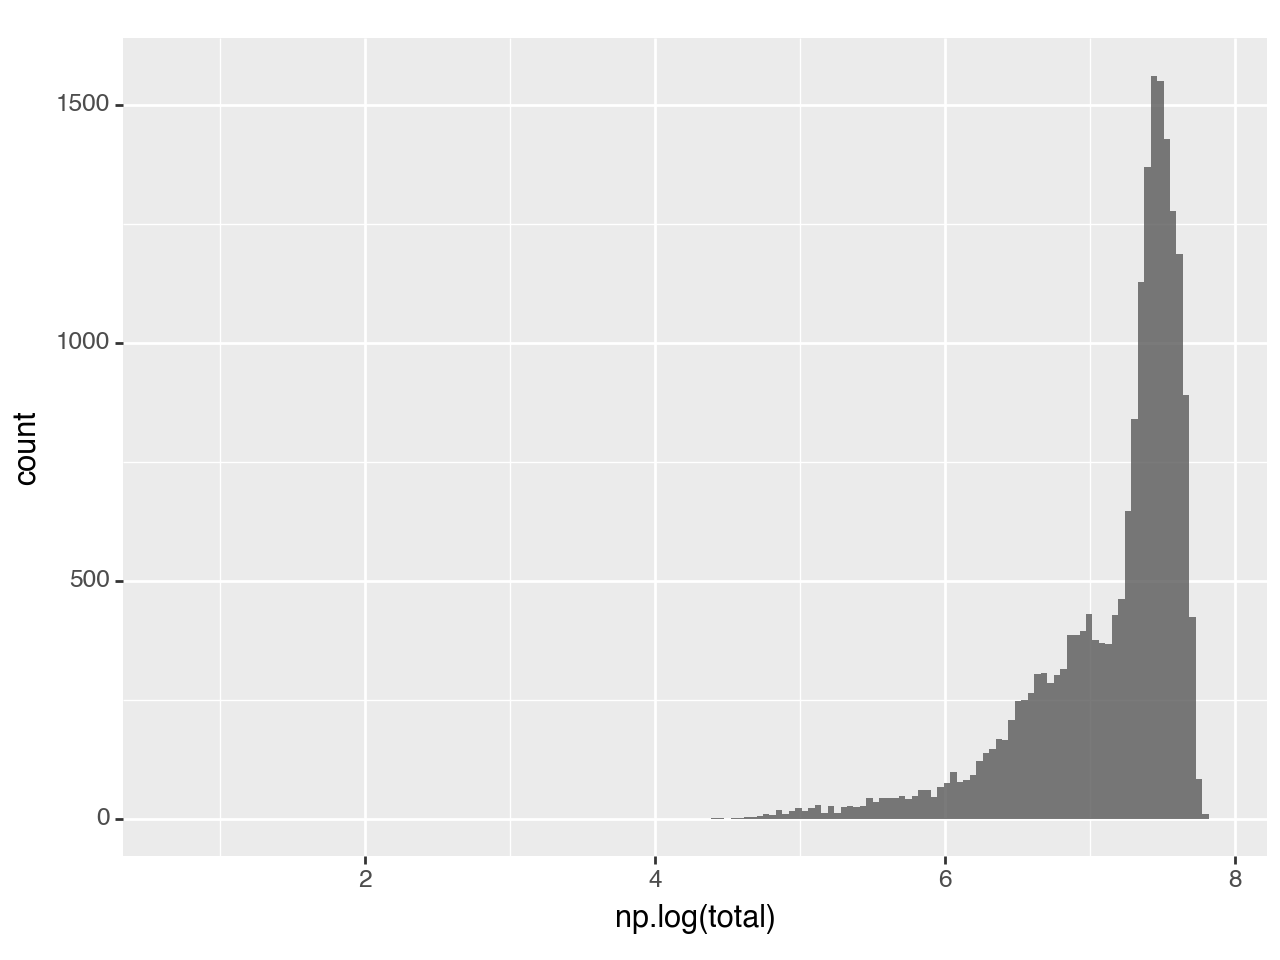

<Figure Size: (640 x 480)>

In [327]:

(
    ggplot(df.loc[y_train.index], aes(x='np.log(total)'))  # Define the source data and the x-axis.
    + geom_histogram(alpha = 0.8)      # Add a histogram layer, adjust binwidth as needed.
    #+ facet_wrap('~hour')
)

In [328]:
feature_importances = model.feature_importances_

for feature_name, importance in zip(X_train.columns, feature_importances):
    print(f"{feature_name}: {importance}")

temp: 0.14590686559677124
wspd: 0.03687596321105957
prcp: 0.009846098721027374
code_Luxembourg: 0.8073710799217224


In [329]:
preds = model.predict(X_test)

In [330]:
mean_squared_error(y_train, model.predict(X_train), squared=False)

0.5243238039101517

In [331]:
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.5356065785989326


In [332]:
treat_res = pd.DataFrame({'residuals': y_test.to_list() - preds, 'total':y_test.to_list()})

In [333]:
treat_res

residuals     total
0     -0.266504  6.837333
1     -0.519735  6.692084
2      0.312780  7.497762
3     -0.081396  7.146772
4      0.247493  7.421776
...         ...       ...
5151   0.117615  7.162397
5152   0.297070  7.393878
5153   0.383660  7.582738
5154   0.274028  7.258412
5155   0.346898  7.581720

[5156 rows x 2 columns]

/Users/dzidoriu/core/py3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 54'. Pick better value with 'binwidth'.


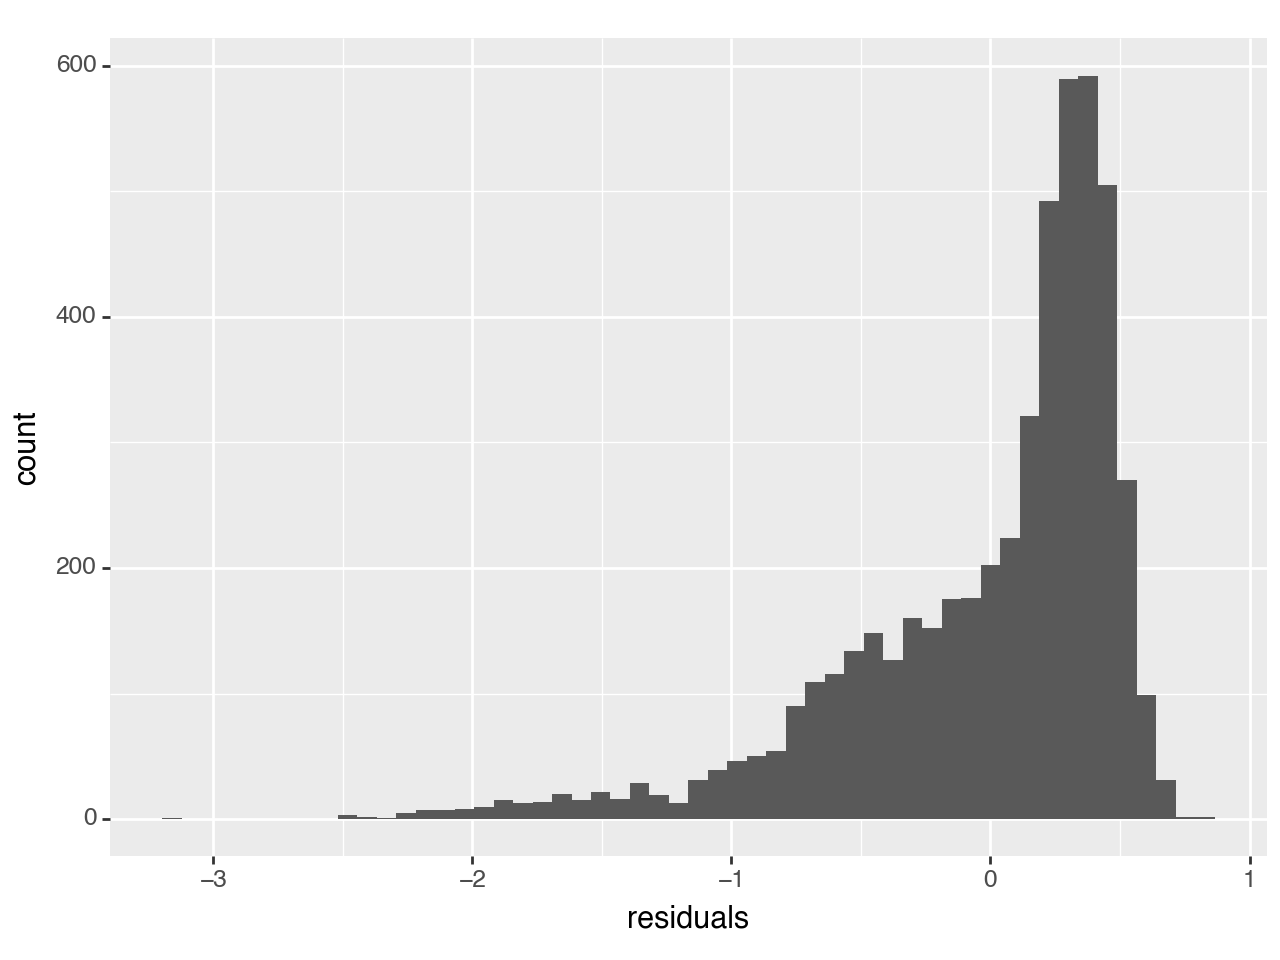

<Figure Size: (640 x 480)>

In [334]:
(
    ggplot(treat_res, aes(x='residuals'))  # Define the source data and the x-axis.
    + geom_histogram()      # Add a histogram layer, adjust binwidth as needed.
)

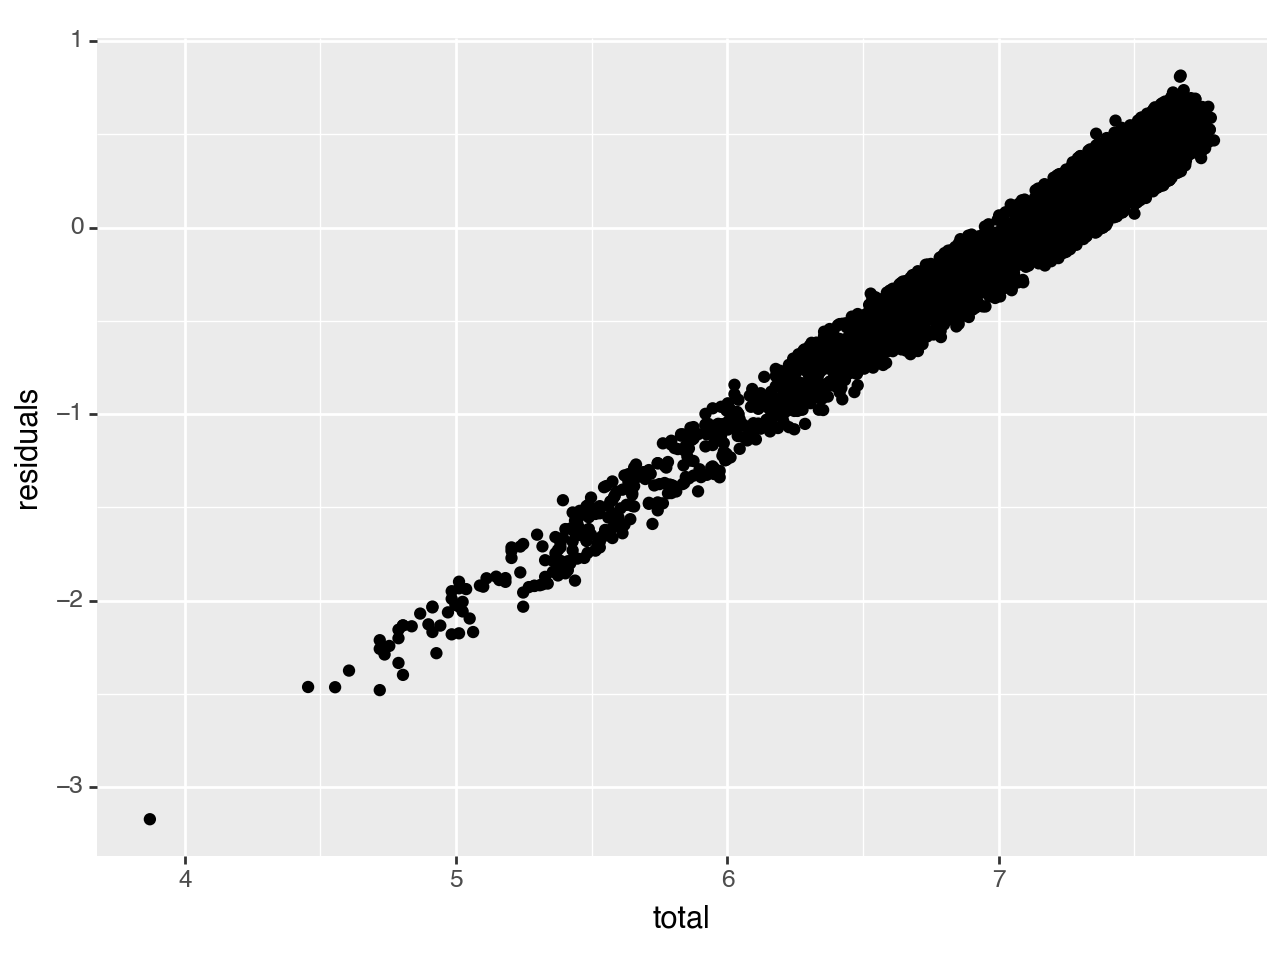

<Figure Size: (640 x 480)>

In [335]:
(
    ggplot(treat_res, aes(x= 'total',y='residuals' ))  # Define the source data and the x-axis.
    + geom_point()      # Add a histogram layer, adjust binwidth as needed.
)

## Outcome model

In [336]:
y_train = np.log(df.loc[y_train.index, 'value'])
y_test = np.log(df.loc[y_test.index, 'value'])

In [337]:
X_train

temp  wspd  prcp  code_Luxembourg
28145   8.2   7.2   0.0                0
10093  16.4  10.8   0.0                1
17471   5.0  36.0   0.0                0
12818   3.1  10.8   0.0                0
26595   6.0  10.8   0.0                1
...     ...   ...   ...              ...
29818  25.4  11.0   0.0                1
13617  20.2  14.4   0.0                0
9081   20.7   3.6   0.0                1
24035   9.5  21.6   0.4                1
31900  14.5  18.0   3.6                1

[20624 rows x 4 columns]

In [338]:
model_out = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.3,
             max_depth = 7, alpha = 10, n_estimators = 100)
model_out.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [339]:
pred_out = model_out.predict(X_test)

In [340]:

print(f"RMSE: {mean_squared_error(y_train, model_out.predict(X_train), squared=False)}")

RMSE: 0.49499311650026606


In [341]:
rmse = mean_squared_error(y_test, pred_out, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.49679335954158144


In [342]:
feature_importances = model_out.feature_importances_

for feature_name, importance in zip(X_train.columns, feature_importances):
    print(f"{feature_name}: {importance}")

temp: 0.006014802027493715
wspd: 0.05594829097390175
prcp: 0.0023810197599232197
code_Luxembourg: 0.9356558918952942


In [343]:
out_res = pd.DataFrame({'outcome': y_test.to_list() - pred_out})

/Users/dzidoriu/core/py3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 53'. Pick better value with 'binwidth'.


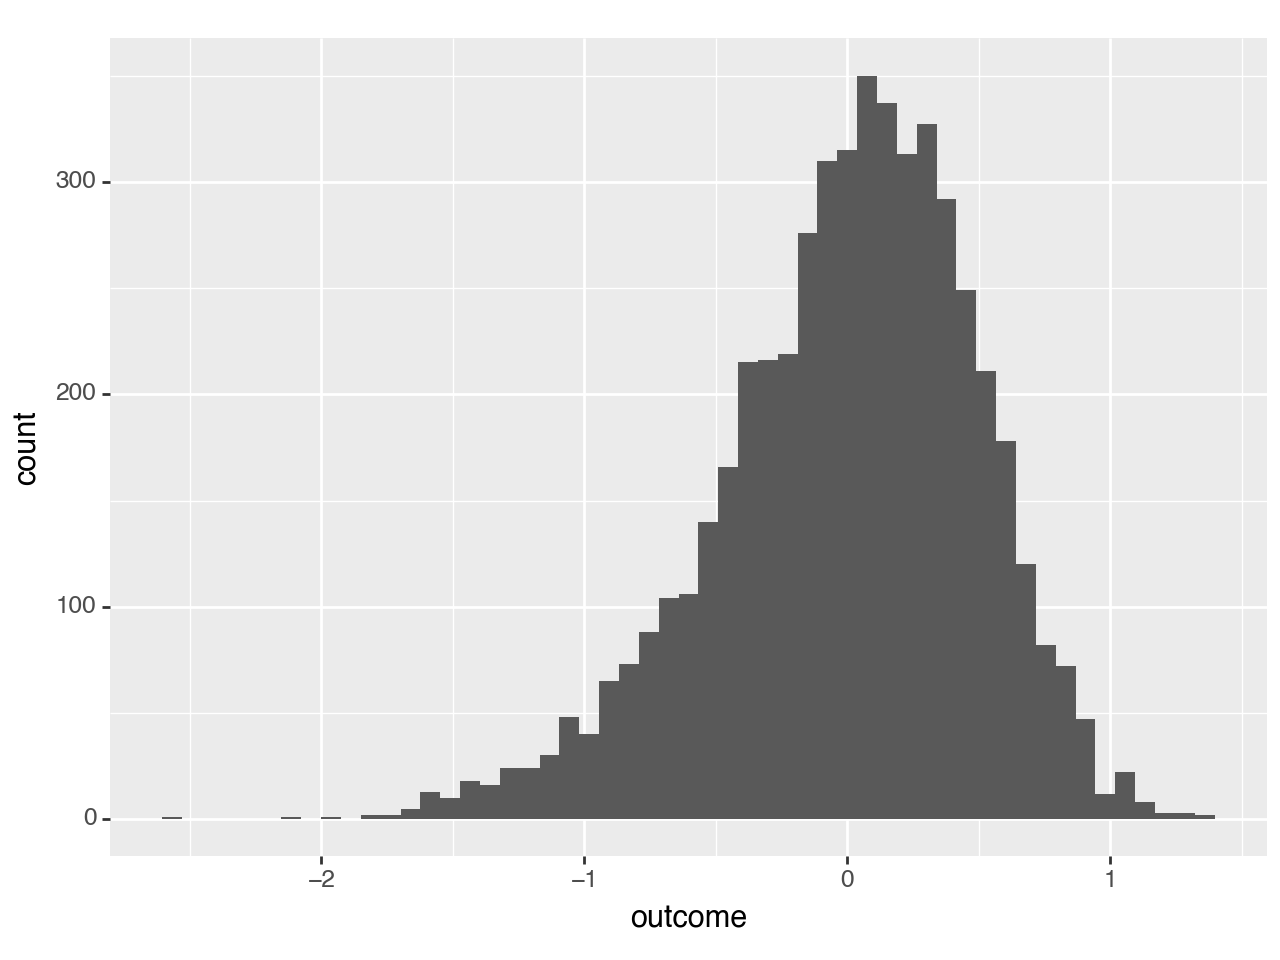

<Figure Size: (640 x 480)>

In [344]:
(
    ggplot(out_res, aes(x='outcome'))  # Define the source data and the x-axis.
    + geom_histogram()      # Add a histogram layer, adjust binwidth as needed.
)

In [345]:
results = pd.concat([treat_res, out_res], axis=1)

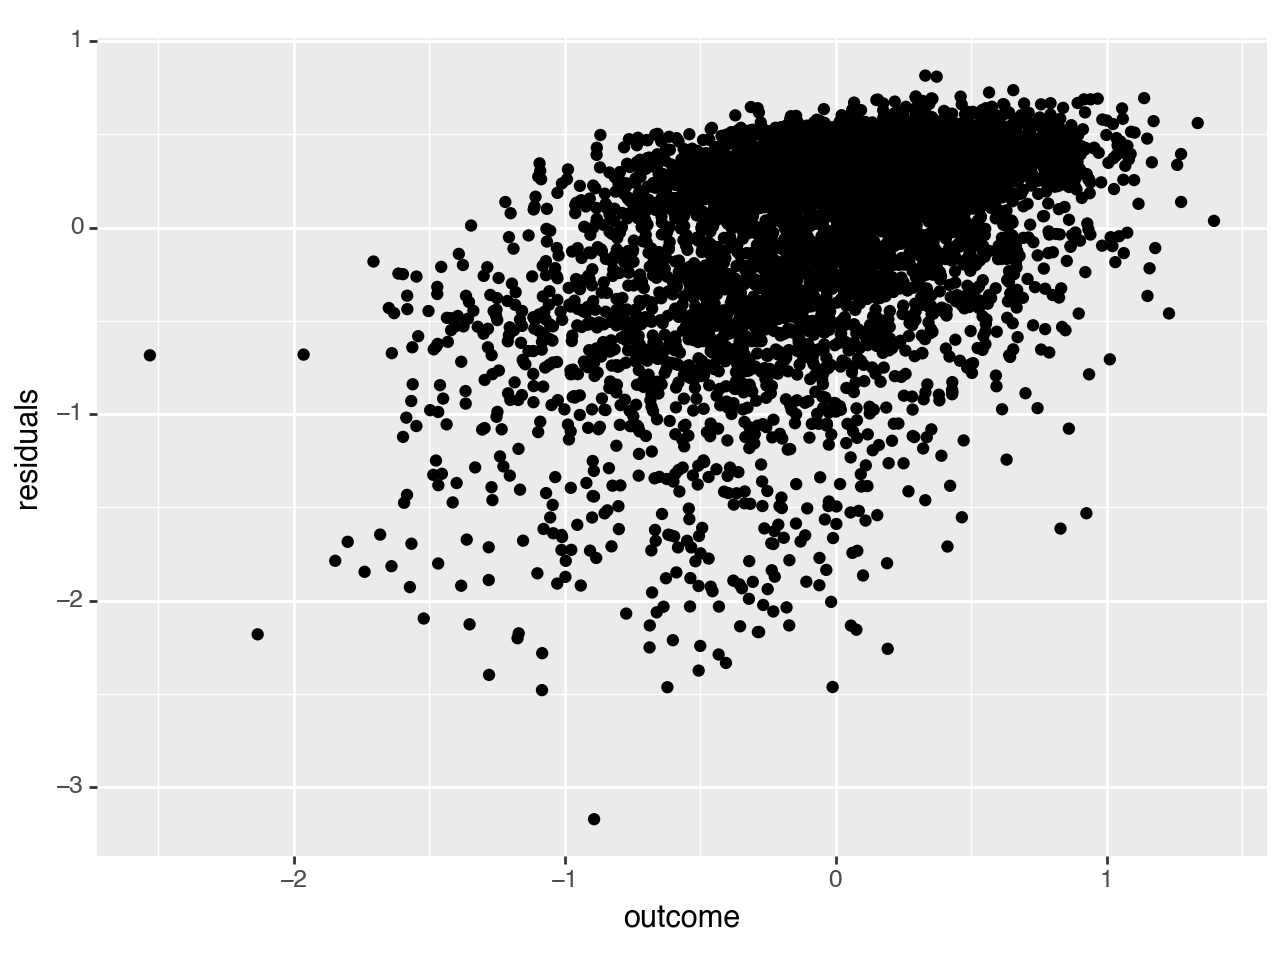

<Figure Size: (640 x 480)>

In [346]:
(
    ggplot(results, aes(x='outcome', y='residuals'))  # Define the source data and the x-axis.
    + geom_point()      # Add a histogram layer, adjust binwidth as needed.
)

In [347]:
results

residuals     total   outcome
0     -0.266504  6.837333  0.296470
1     -0.519735  6.692084 -0.913110
2      0.312780  7.497762  0.098214
3     -0.081396  7.146772  0.209649
4      0.247493  7.421776 -0.074416
...         ...       ...       ...
5151   0.117615  7.162397 -0.421886
5152   0.297070  7.393878  0.445447
5153   0.383660  7.582738  0.387015
5154   0.274028  7.258412 -0.363198
5155   0.346898  7.581720  0.450926

[5156 rows x 3 columns]

In [348]:
model = smf.ols("outcome ~ residuals", data = results).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     1499.
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          5.09e-288
Time:                        17:13:33   Log-Likelihood:                -3050.6
No. Observations:                5156   AIC:                             6105.
Df Residuals:                    5154   BIC:                             6118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0009      0.006     -0.148      0.8

## Linear model

### All variables

In [349]:
X = df.drop(['value'], axis=1)
y = np.log(df['value'])
X

total  temp  wspd  prcp  code_Luxembourg
8221     240   9.1  14.4   0.0                0
8222     112   9.1  14.4   0.0                1
8223     154   4.7   7.2   0.0                0
8224     136   4.7   7.2   0.0                1
8225     952   8.2  28.8   0.0                0
...      ...   ...   ...   ...              ...
34027    430   5.5  14.4   0.0                1
34028    350  11.5   3.6   0.0                1
34029    536  17.0  10.8   0.0                1
34030    528  11.0  14.4   0.0                1
34031    564   8.2  14.4   0.0                1

[25780 rows x 5 columns]

In [350]:
X.total = np.log(X.total)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [351]:
X_train

total  temp  wspd  prcp  code_Luxembourg
29297  7.468513  20.0  18.0   0.0                0
16272  7.458186  12.2  25.2   0.0                1
28103  7.427739   4.7  10.8   0.0                0
11950  6.656727   0.1  14.4   0.0                1
12373  7.515345   0.5  10.8   0.0                1
...         ...   ...   ...   ...              ...
29818  6.562444  25.4  11.0   0.0                1
13617  7.606885  20.2  14.4   0.0                0
9081   6.866933  20.7   3.6   0.0                1
24035  7.474205   9.5  21.6   0.4                1
31900  6.302619  14.5  18.0   3.6                1

[23202 rows x 5 columns]

In [352]:
X = sm.add_constant(X_train)

In [353]:
model_lin = sm.OLS(y_train, X).fit()

In [354]:
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     4274.
Date:                Sun, 17 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:13:56   Log-Likelihood:                -14120.
No. Observations:               23202   AIC:                         2.825e+04
Df Residuals:                   23196   BIC:                         2.830e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.9154      0.040     

### Total effect model

In [355]:
X = df[['total', 'value']]
X = X.drop(['value'], axis=1)
y = np.log(df['value'])

X.total = np.log(X.total)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)



In [356]:
X = sm.add_constant(X_train)
model_lin = sm.OLS(y_train, X).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     5266.
Date:                Sun, 17 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:16:13   Log-Likelihood:                -19321.
No. Observations:               23202   AIC:                         3.865e+04
Df Residuals:                   23200   BIC:                         3.866e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1978      0.048     -4.090      0.0

### DoubleML, Bayesian simulation of intervals

In [559]:
import pymc3 as pm

In [560]:
treatment_variable = results.residuals
outcome_variable = results.outcome

In [439]:
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta * treatment_variable

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=outcome_variable)

    # Draw posterior samples
    trace = pm.sample(1000)


/Users/dzidoriu/core/py3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


/var/folders/dx/gx55fj5d24g06sqg2dykf1mh0000gr/T/ipykernel_47803/3652980741.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not usi

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -0.003  0.005  -0.012    0.006        0.0      0.0    5388.0    2864.0   
beta   0.228  0.005   0.218    0.238        0.0      0.0    5474.0    2616.0   
sigma  0.496  0.003   0.490    0.502        0.0      0.0    5430.0    3253.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0

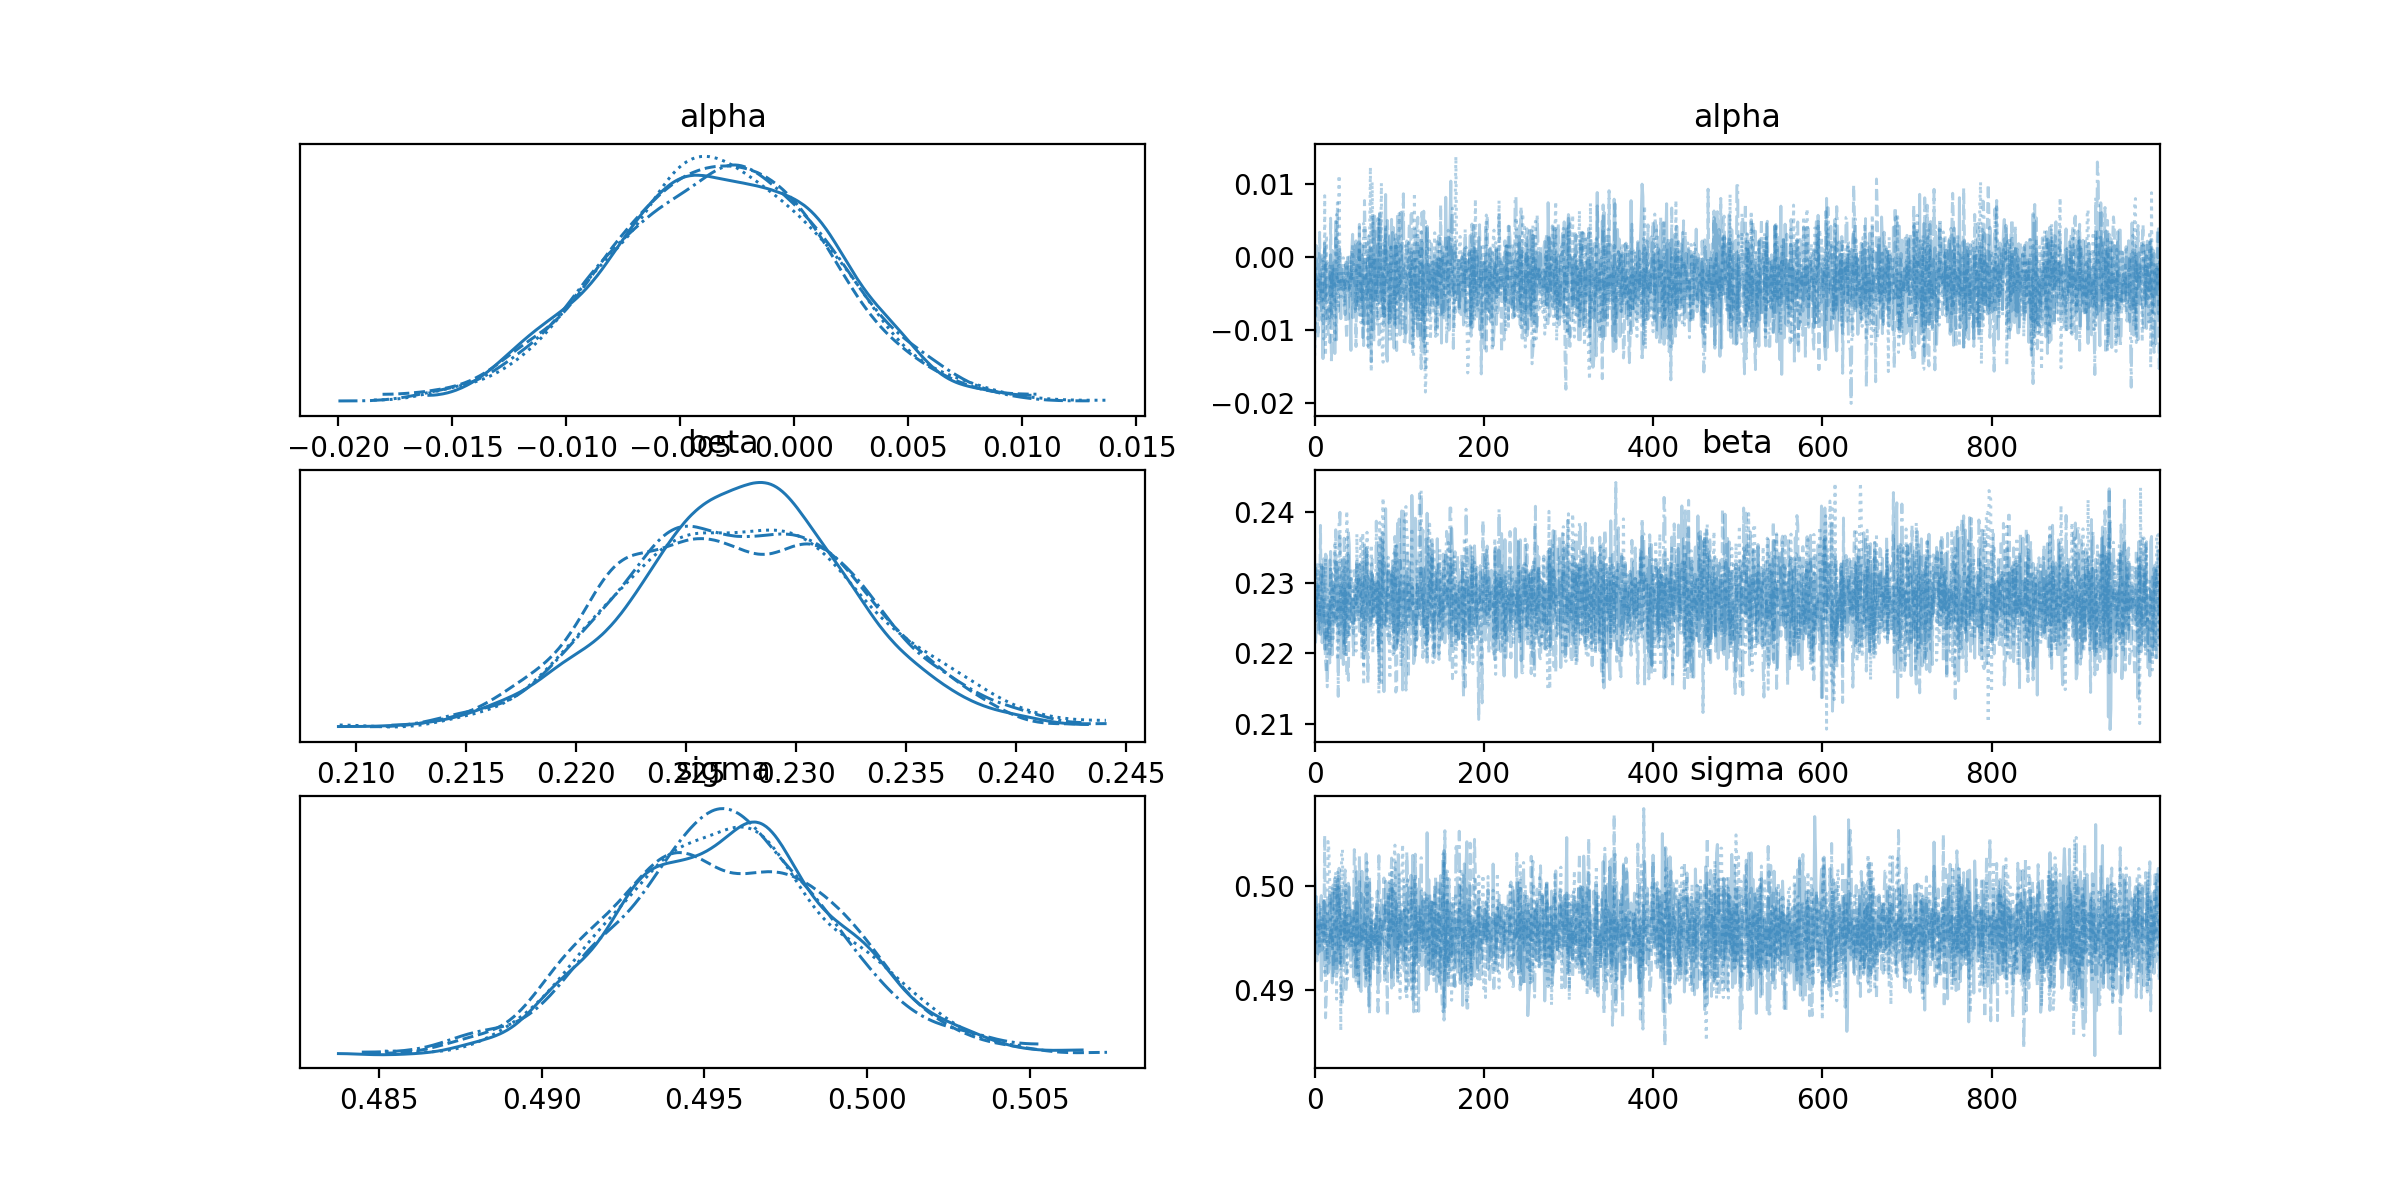

In [440]:
pm.traceplot(trace)
pm.summary(trace)


### Bayesian approach - treatment only

In [270]:

y = np.log(df['value'])

x = np.log(df.total)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8895773438012525, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/dx/gx55fj5d24g06sqg2dyk

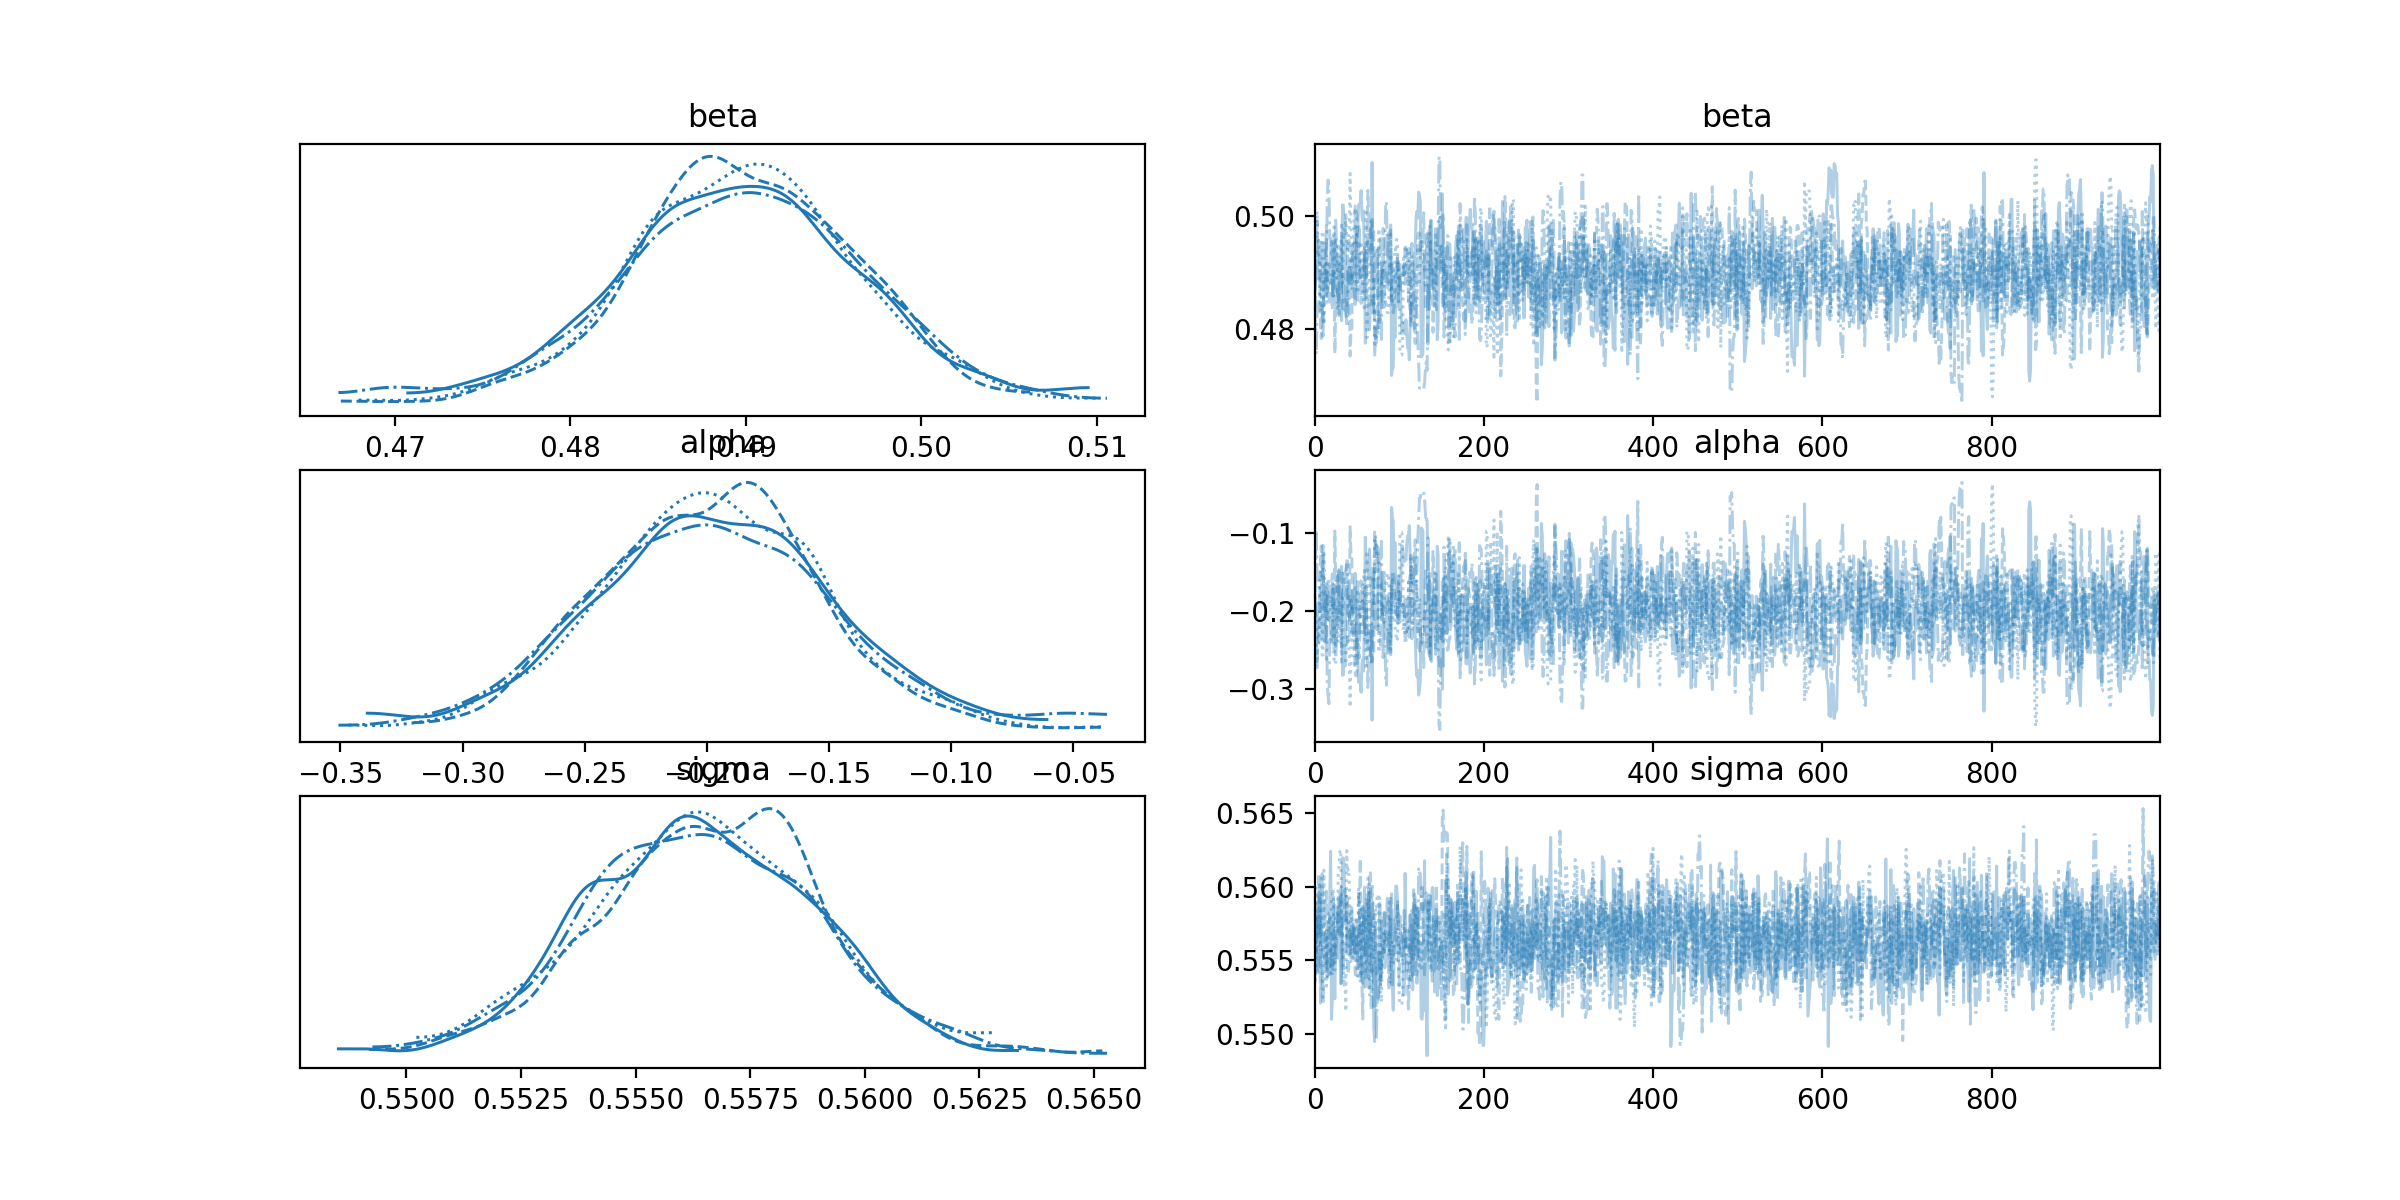

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   0.490  0.007   0.478    0.503      0.000    0.000    1158.0    1357.0   
alpha -0.198  0.047  -0.289   -0.112      0.001    0.001    1156.0    1307.0   
sigma  0.556  0.002   0.552    0.561      0.000    0.000    1978.0    1778.0   

       r_hat  
beta     1.0  
alpha    1.0  
sigma    1.0  


In [281]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt


with pm.Model() as model:
    # Priors for model parameters
    beta = pm.Normal('beta', mu=0, sigma=10)
    alpha = pm.Normal('alpha', mu=0, sigma=5)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear regression model
    mu = alpha + beta * x

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    # Posterior sampling
    trace = pm.sample(1000, return_inferencedata=False)

# Plotting the results
pm.traceplot(trace)
plt.show()

# Summary of the trace
print(pm.summary(trace))


In [359]:
df

total  value  temp  wspd  prcp  code_Luxembourg
8221     240   11.0   9.1  14.4   0.0                0
8222     112   10.0   9.1  14.4   0.0                1
8223     154   20.0   4.7   7.2   0.0                0
8224     136   22.0   4.7   7.2   0.0                1
8225     952   38.0   8.2  28.8   0.0                0
...      ...    ...   ...   ...   ...              ...
34027    430   21.0   5.5  14.4   0.0                1
34028    350   26.0  11.5   3.6   0.0                1
34029    536   23.0  17.0  10.8   0.0                1
34030    528   16.0  11.0  14.4   0.0                1
34031    564   15.0   8.2  14.4   0.0                1

[25780 rows x 6 columns]

### Bayesian, multivariable

In [365]:

with pm.Model() as model:
    # Priors for model parameters
    intercept = pm.HalfNormal('intercept', sigma=5)
    
    beta = pm.Normal('beta', mu=0, sigma=3)    
    beta_temp = pm.Normal('beta_temp', mu=0, sigma=2)
    beta_wspd = pm.Normal('beta_wspd', mu=0, sigma=2)
    beta_prcp = pm.Normal('beta_prcp', mu=0, sigma=2)
    beta_code_Lux = pm.Normal('beta_code_Lux', mu=0, sigma=2)
    
    #beta_rush = pm.Normal('beta_rush', mu=0, sigma=5)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear regression model
    mu = intercept + beta * np.log(df.total) + beta_temp * df.temp + beta_wspd * df.wspd + \
        beta_prcp * df.prcp + beta_code_Lux * df.code_Luxembourg
        

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=np.log(df['value']))

    # Posterior sampling
    trace = pm.sample(1000, return_inferencedata=False)





Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_code_Lux, beta_prcp, beta_wspd, beta_temp, beta, intercept]


/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 176 seconds.
The acceptance probability does not match the target. It is 0.9794219936990152, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
Got error No model on context stack. trying to find log_likelihood in translation.


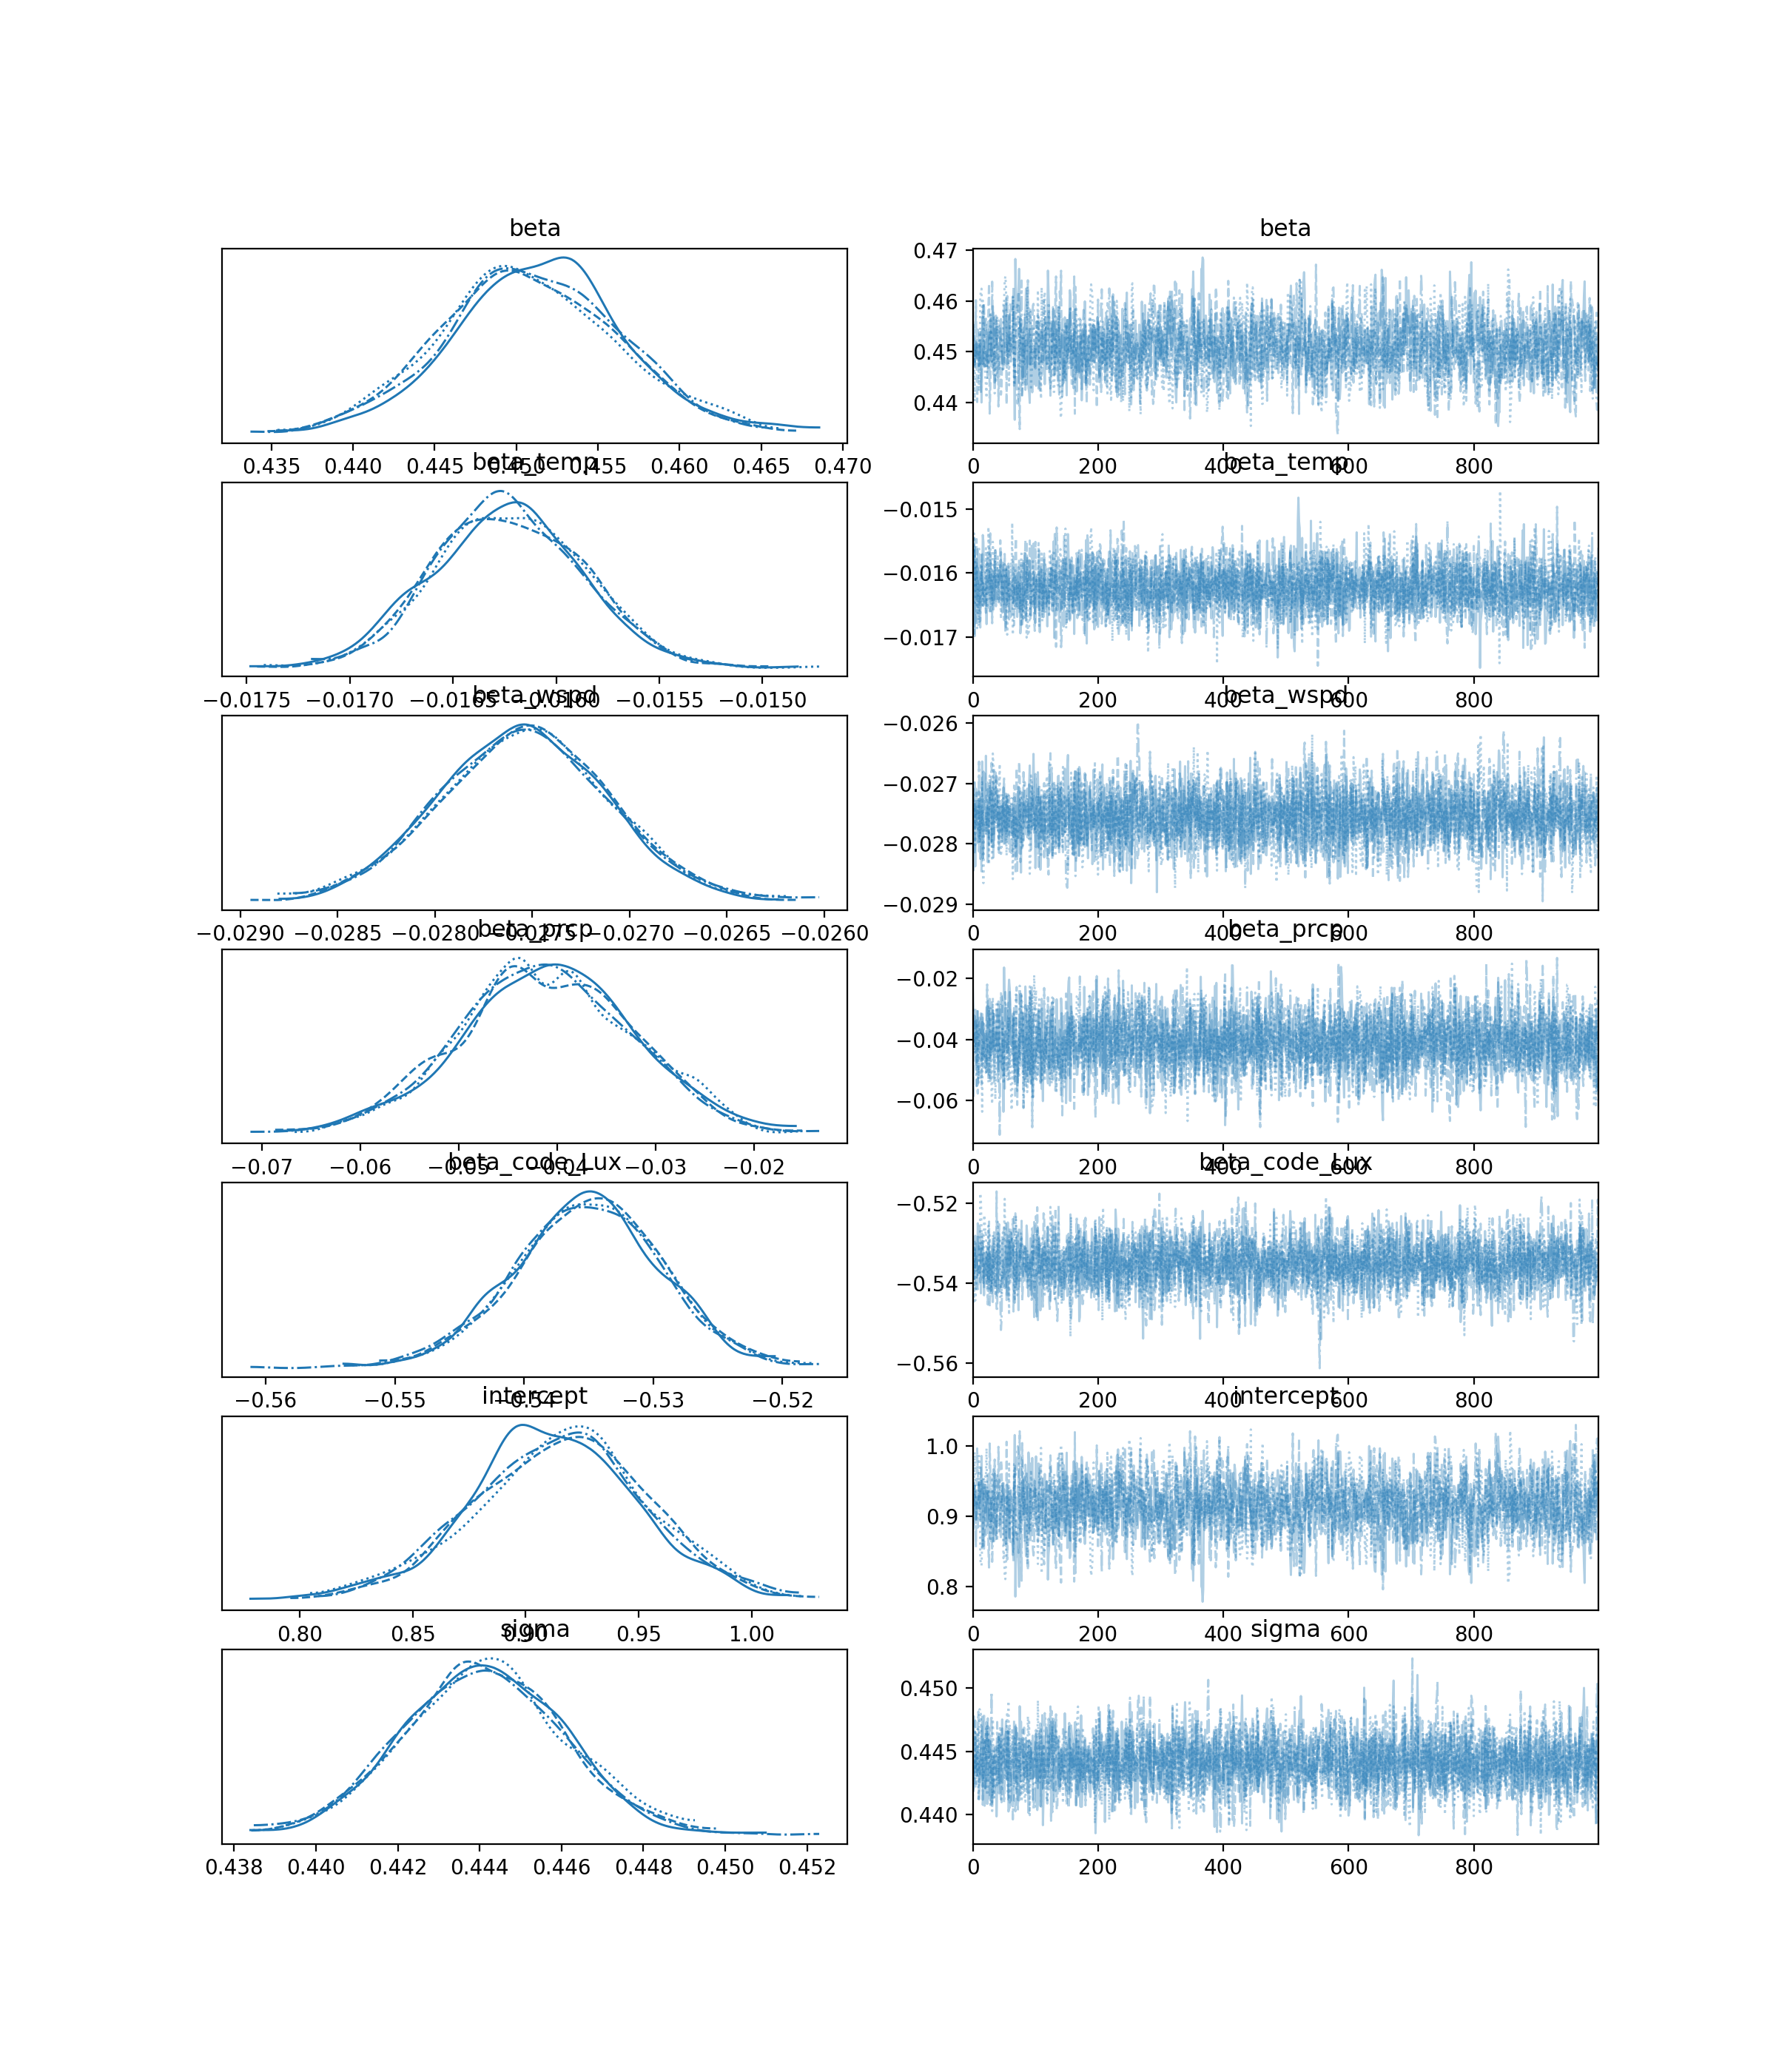

In [366]:
# Plotting the results
pm.plot_trace(trace)
plt.show()

In [367]:
# Summary of the trace
print(pm.summary(trace))

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/dzidoriu/core/py3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta           0.451  0.005   0.441    0.461      0.000    0.000    1544.0   
beta_temp     -0.016  0.000  -0.017   -0.016      0.000    0.000    3533.0   
beta_wspd     -0.028  0.000  -0.028   -0.027      0.000    0.000    3432.0   
beta_prcp     -0.041  0.009  -0.058   -0.025      0.000    0.000    3535.0   
beta_code_Lux -0.535  0.006  -0.546   -0.525      0.000    0.000    3467.0   
intercept      0.914  0.039   0.838    0.987      0.001    0.001    1698.0   
sigma          0.444  0.002   0.440    0.448      0.000    0.000    3445.0   

               ess_tail  r_hat  
beta             2155.0    1.0  
beta_temp        2771.0    1.0  
beta_wspd        2826.0    1.0  
beta_prcp        2807.0    1.0  
beta_code_Lux    2900.0    1.0  
intercept        2171.0    1.0  
sigma            2550.0    1.0  


In [282]:
np.log(df['value']).describe()

count    25780.000000
mean         3.301695
std          0.616391
min          0.693147
25%          2.890372
50%          3.401197
75%          3.761200
max          4.927254
Name: value, dtype: float64

In [283]:
np.log(df['total']).describe()

count    25780.000000
mean         7.144789
std          0.540979
min          0.693147
25%          6.897705
50%          7.356280
75%          7.513164
max          7.824046
Name: total, dtype: float64